In [1]:
import os
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy as spy
import itertools
import seaborn as sns
import powerlaw
from scipy.interpolate import interp1d

In [47]:
def InputFunction(A):
    ## Input:
    # A is a numpy array of the adjacency matrix

    ## Output:
    # All_inters is a list of all cliques (i.e., the complex sub-graph), which is obtained based on the outputs of the algorithm proposed by Bron and Kerbosch 
    # Ref: Bron, C. and Kerbosch, J. “Algorithm 457: finding all cliques of an undirected graph”. Communications of the ACM 16, 9 (Sep. 1973), 575–577.
    
    ## Please note that the length of the clique list may be a exponential function of the number of Nodes in the worst case
    ## This function depends on the the Networkx toolbox

    G = nx.from_numpy_array(A) # The graph variable acceptable for the Networkx toolbox
    All_inters=[tuple(list(itertools.combinations(Inters,ID))) for Inters in list(nx.find_cliques(G)) for ID in range(1,len(Inters)+1)] 
    # Note that here the tuple is used to make the type hashable as required by Python
    All_inters=list(set([Inters[ID] for Inters in All_inters for ID in range(len(Inters))])) # The list of all cliques
    return All_inters


def HighOrderLaplician(Num, All_inters, Type, Order):
    ## Input: 
    # Num is the number of Nodes in the graph
    # All_inters is a list of all cliques (i.e., the complex sub-graph), which is generated by the InputFunction

    # Type is a str that determines which type of high order Laplician representation to use
    # Type='MOL'： the function generates the multi-order Laplacian operator, which is 
    # Type='HOPL'： the function generates the high-order path Laplacian operator proposed in our work

    # Order is a number that determines which order of interactions to analyze

    ## Output:
    # (1) SC contains the simplicial complex of a corresponding order
    # (2) L is the high order Laplician representation, which is the Multiorder Laplacian operator or the high-order path Laplacian
    SC=[Simplex for Simplex in All_inters if len(Simplex)==Order+1]
    if len(SC)>0:
        if Type=='MOL': # the multi-order Laplacian operator
            HO_A = np.zeros((Num, Num))
            for Simplex in SC:
                for [i, j] in itertools.combinations(Simplex,2):
                    HO_A[i,j] += 1
            HO_A += HO_A.T
            #HO_A = (HO_A!=0).astype(int)
            HO_D = sum(HO_A)
            L = Order * np.diag(HO_D) - HO_A
        elif Type=='HOPL': # the high-order path Laplacian operator
            HO_A = np.zeros((Num, Num))
            for Simplex in SC:
                for [i, j] in itertools.combinations(Simplex,2):
                    HO_A[i,j] += 1
            HO_A += HO_A.T
            #HO_A = (HO_A!=0).astype(int)
            HO_D = sum(HO_A)
            L = np.diag(HO_D) - HO_A   
    else:
        L=np.zeros((Num,Num))
    return SC,L

def NetworkInfo(L):
    ## Input: 
    # L is the high order Laplician representation, which can be the Multiorder Laplacian operator or the high-order path Laplacian

    ## Output:
    # Sub_Ls the list of the sub-Laplician-matrices associated with all connected components from L
    # Sub_NodeIDs is the list of sub-node-indice associated with all connected components from L
    G=nx.from_numpy_array(np.abs(L)-np.diag(np.diag(L)))
    Sub_Ls=[L[list(SG),:][:,list(SG)] for SG in nx.connected_components(G)] 
    Sub_NodeIDs=[list(SG) for SG in nx.connected_components(G)]
    return Sub_Ls, Sub_NodeIDs

def NetworkUnion(Sub_Ls):
    L=np.ones((1,1))
    for SL in Sub_Ls:
        L=spy.linalg.block_diag(L,SL)
    L=L[1:,1:]
    return L
    
def SRGFlow(L,L0,q,InterNum):
    ## Input: 
    # L is the initial guiding high order Laplician representation, which can be the Multiorder Laplacian operator or the high-order path Laplacian
    # L0 is the initial guided high order Laplician representation, which can be the Multiorder Laplacian operator or the high-order path Laplacian

    ## Output:
    # FPL (fixed point L) is the high order Laplician representation at the fixed point of the SRG (simplex renormalization) flow 
    Inter=1
    Init_Sub_Ls,_=NetworkInfo(L)
    L_List=[L]
    L0_List=[L0]
    tau_Vec=np.zeros(len(Init_Sub_Ls))
    CList=[]
    for ID in range(len(Init_Sub_Ls)):
        if np.size(Init_Sub_Ls[ID],0)>1:
            tau,CVector=TauSelection(Init_Sub_Ls[ID])
            tau=tau/((q+1)/2)
            tau_Vec[ID]=tau
            CList.append(CVector)
    while Inter<InterNum:
        Current_L=L_List[Inter-1]
        Current_L0=L0_List[Inter-1]
        Current_G0=nx.from_numpy_array(np.abs(Current_L0)-np.diag(np.diag(Current_L0)))
        ToDelete0 = set([])
        Sub_Ls, Sub_NodeIDs=NetworkInfo(Current_L)
        NewSub_Ls=[]
        for SLID in range(len(Sub_Ls)):
            SL=Sub_Ls[SLID]
            SNodeID = Sub_NodeIDs[SLID]
            if np.size(SL,0)==1:
                NewSub_Ls.append(SL)
            else: 
                Evals, _ = np.linalg.eig(SL)
                Evals[np.where(Evals<0)]=0
                tau=tau_Vec[SLID]
                Lsorted_Idx = np.argsort(-Evals)
                SEvals = np.real(Evals[Lsorted_Idx])
                Idx, = np.where(SEvals<=1/tau)
                Nn = len(Idx)
                print(['Nn:',Nn])
                if Nn<=1:
                    NewSub_Ls.append(np.zeros((1,1)))
                    if len(SNodeID) == 1:
                        continue
                    Node1 = SNodeID[0]
                    for node in SNodeID[1:]:
                        Neighbors = list(Current_G0.neighbors(node))
                        new_edges = [(Node1, Nei) for Nei in Neighbors if Node1!=Nei] 
                        Current_G0.add_edges_from(new_edges)
                        ToDelete0.add(node)
                else:
                    Rho = spy.linalg.expm(-tau*SL)/np.trace(spy.linalg.expm(-tau*SL))
                    Abs_Rho = np.triu(Rho, k=1)
                    Rhosort_Idx = np.argsort(-Abs_Rho.reshape(-1))
                    Rows, Cols = np.unravel_index(Rhosort_Idx, (Rho.shape[0], Rho.shape[1]))

                    RefG = nx.Graph() # reference graph
                    RefG.add_nodes_from(range(SL.shape[0]))
                    RefG_com = list(nx.connected_components(RefG))
                    for ID in range(len(Rows)):
                        if len(RefG_com) == Nn:
                            break
                        if Rows[ID]==Cols[ID]:
                            continue
                        Node1, Node2 = Rows[ID], Cols[ID]
                        RefG.add_edges_from([(Node1,Node2)])
                        RefG_com = list(nx.connected_components(RefG))

                    Current_SG=nx.from_numpy_array(np.abs(SL)-np.diag(np.diag(SL)))
                    ToDelete = set([])
                    for Nodes in RefG_com:
                        Node_list = list(Nodes)
                        if len(Node_list) == 1:
                            continue
                        Node1 = Node_list[0]
                        for node in Node_list[1:]:
                            Neighbors = list(Current_SG.neighbors(node))
                            new_edges = [(Node1, Nei) for Nei in Neighbors if Node1!=Nei]
                            Current_SG.add_edges_from(new_edges)
                            ToDelete.add(node)
                    Current_SG.remove_nodes_from(ToDelete)
                    New_SA = nx.adjacency_matrix(Current_SG).toarray()

                    for Nodes in RefG_com:
                        SNode_list = [SNodeID[node] for node in Nodes]
                        if len(SNode_list) == 1:
                            continue
                        Node1 = SNode_list[0]
                        for node in SNode_list[1:]:
                            Neighbors = list(Current_G0.neighbors(node))
                            new_edges = [(Node1, Nei) for Nei in Neighbors if Node1!=Nei]
                            Current_G0.add_edges_from(new_edges)
                            ToDelete0.add(node)
                        
                    New_SL = np.diag(np.sum(New_SA,axis=0)) - New_SA
                    NewSub_Ls.append(New_SL)

        Current_G0.remove_nodes_from(ToDelete0)
        New_A0 = nx.adjacency_matrix(Current_G0).toarray()
        New_L0 = np.diag(np.sum(New_A0,axis=0)) - New_A0
        
        New_Eval0s, _ = np.linalg.eig(New_L0)
        Eval0s, _ = np.linalg.eig(Current_L0)
        _ , New_bins0 = np.histogram(np.real(New_Eval0s), range=(0,np.real(New_Eval0s).max()), bins=500, density=True)
        _ , Bins0 = np.histogram(np.real(Eval0s), range=(0,np.real(Eval0s).max()), bins=500, density=True)
        New_L0 =  Bins0[1]/New_bins0[1] * New_L0
        print('Chi0: {}'.format(Bins0[1]/New_bins0[1]))

        New_L=NetworkUnion(NewSub_Ls)
        New_Evals, _ = np.linalg.eig(New_L)
        Evals, _ = np.linalg.eig(Current_L)
        _ , New_bins = np.histogram(np.real(New_Evals), range=(0,np.real(New_Evals).max()), bins=500, density=True)
        _ , Bins = np.histogram(np.real(Evals), range=(0,np.real(Evals).max()), bins=500, density=True)
        New_L =  Bins[1] / New_bins[1] * New_L
        print('Chi: {}'.format(Bins[1]/New_bins[1]))

        L_List.append(New_L)
        L0_List.append(New_L0)
        Inter=Inter+1
    return L_List,CList,L0_List

def TauSelection(L):
    ## Input: 
    # L is the initial high order Laplician representation, which can be the Multiorder Laplacian operator or the high-order path Laplacian

    ## Output:
    # tau is the ideal constant that determines the time scale
    Evals, _ = np.linalg.eig(L)
    Evals[np.where(Evals<0)]=0
    TauVec=np.linspace(0.01, 5, 200) 
    MLambdaVector=np.zeros_like(TauVec)
    for ID in range(len(TauVec)):
        Poss_tau=TauVec[ID]
        MatixExp=spy.linalg.expm(-Poss_tau*L)
        Z=np.trace(MatixExp)
        Rho=MatixExp/Z
        MLambdaVector[ID]=np.trace(L @ Rho)
    CVector=-np.power(TauVec[1:],2)*np.diff(MLambdaVector)/np.diff(TauVec)
    tau=TauVec[np.argmax(CVector)+1]
    print(['our method: tau is ',tau,'!!'])
    return tau,CVector

def get_plot_colors(n, type='Blues'):
    if type == 'Blues':
        colors = plt.cm.Blues(np.linspace(0, 1, n))
    elif type == 'YlGnBu':
        colors = plt.cm.YlGnBu(np.linspace(0, 1, n))
    elif type == 'GnBu':
        colors = plt.cm.GnBu(np.linspace(0, 1, n))
    elif type == 'viridis':
        colors = plt.cm.viridis(np.linspace(0, 1, n))    
    return colors

## Inverse transform sampling for generating a random variable Y that is identically and indpendently distributed according to variable X
def InverseTransformSampling(X, Bins, SampleSize):
    # X: the samples of a target random variable X
    # Bins: the number of bins or a monotonically increasing array of bin edges unsed on X
    # SampleSize: the number of samples of variable Y, where Y is an identically and indpendently distributed variable with X
    Prob, Edges = np.histogram(X, Bins, density=True)
    CDF = np.zeros_like(Edges)
    CDF[1:] = np.cumsum(Prob*(Edges[1:]-Edges[:-1]))
    InverseCDF = interp1d(CDF, Edges)
    U = np.random.rand(SampleSize)
    Y = InverseCDF(U)
    return Y

In [51]:
# experiment settings
Sample_Num = 10
q,p,m = 1,1,1
net_type = 'BA'
L_type = 'MOL'
save_path = osp.join('.','experiments','{}_{}'.format(net_type, L_type),'q{}_p{}_m{}'.format(q,p,m))
if not osp.exists(save_path):
    os.makedirs(save_path)

L_Lists = []
C_Lists = []
L0_Lists = []

In [53]:
# SRG flow
for i in range(Sample_Num):
    try:
        L_List, L0_List = [], []
        C_List = np.load(osp.join(save_path,'C_s{}.npy'.format(i)))
        for j in range(5):
            L_j = np.load(osp.join(save_path,'L_s{}_{}.npy'.format(i,j)))
            L0_j = np.load(osp.join(save_path,'L0_s{}_{}.npy'.format(i,j)))
            L_List.append(L_j)
            L0_List.append(L0_j)
        L_Lists.append(L_List)
        C_Lists.append(C_List)
        L0_Lists.append(L0_List)
    except:
        if net_type=='BA':
            A=nx.adjacency_matrix(nx.random_graphs.barabasi_albert_graph(1000,m))
        elif net_type=='ER':
            A=nx.adjacency_matrix(nx.erdos_renyi_graph(1000,m))
        elif net_type=='WS':
            A=nx.adjacency_matrix(nx.watts_strogatz_graph(1000,5,m,seed=None))
        elif net_type=='RT':
            A=nx.adjacency_matrix(nx.random_tree(1000))
        elif net_type=='TL':
            A=nx.adjacency_matrix(nx.triangular_lattice_graph(40, 25, periodic=False, with_positions=True, create_using=None))

        _,L=HighOrderLaplician(np.size(A,0), InputFunction(A), Type=L_type, Order=q)
        _,L0=HighOrderLaplician(np.size(A,0), InputFunction(A), Type=L_type, Order=p)

        L_List,C_List,L0_List=SRGFlow(L,L0,q,InterNum=5)
        np.save(osp.join(save_path,'C_s{}.npy'.format(i)),C_List)
        for j in range(len(L_List)):
            np.save(osp.join(save_path,'L_s{}_{}.npy'.format(i,j)),L_List[j])             
            np.save(osp.join(save_path,'L0_s{}_{}.npy'.format(i,j)),L0_List[j])
        L_Lists.append(L_List)
        C_Lists.append(C_List)
        L0_Lists.append(L0_List)


0.9925715611152255


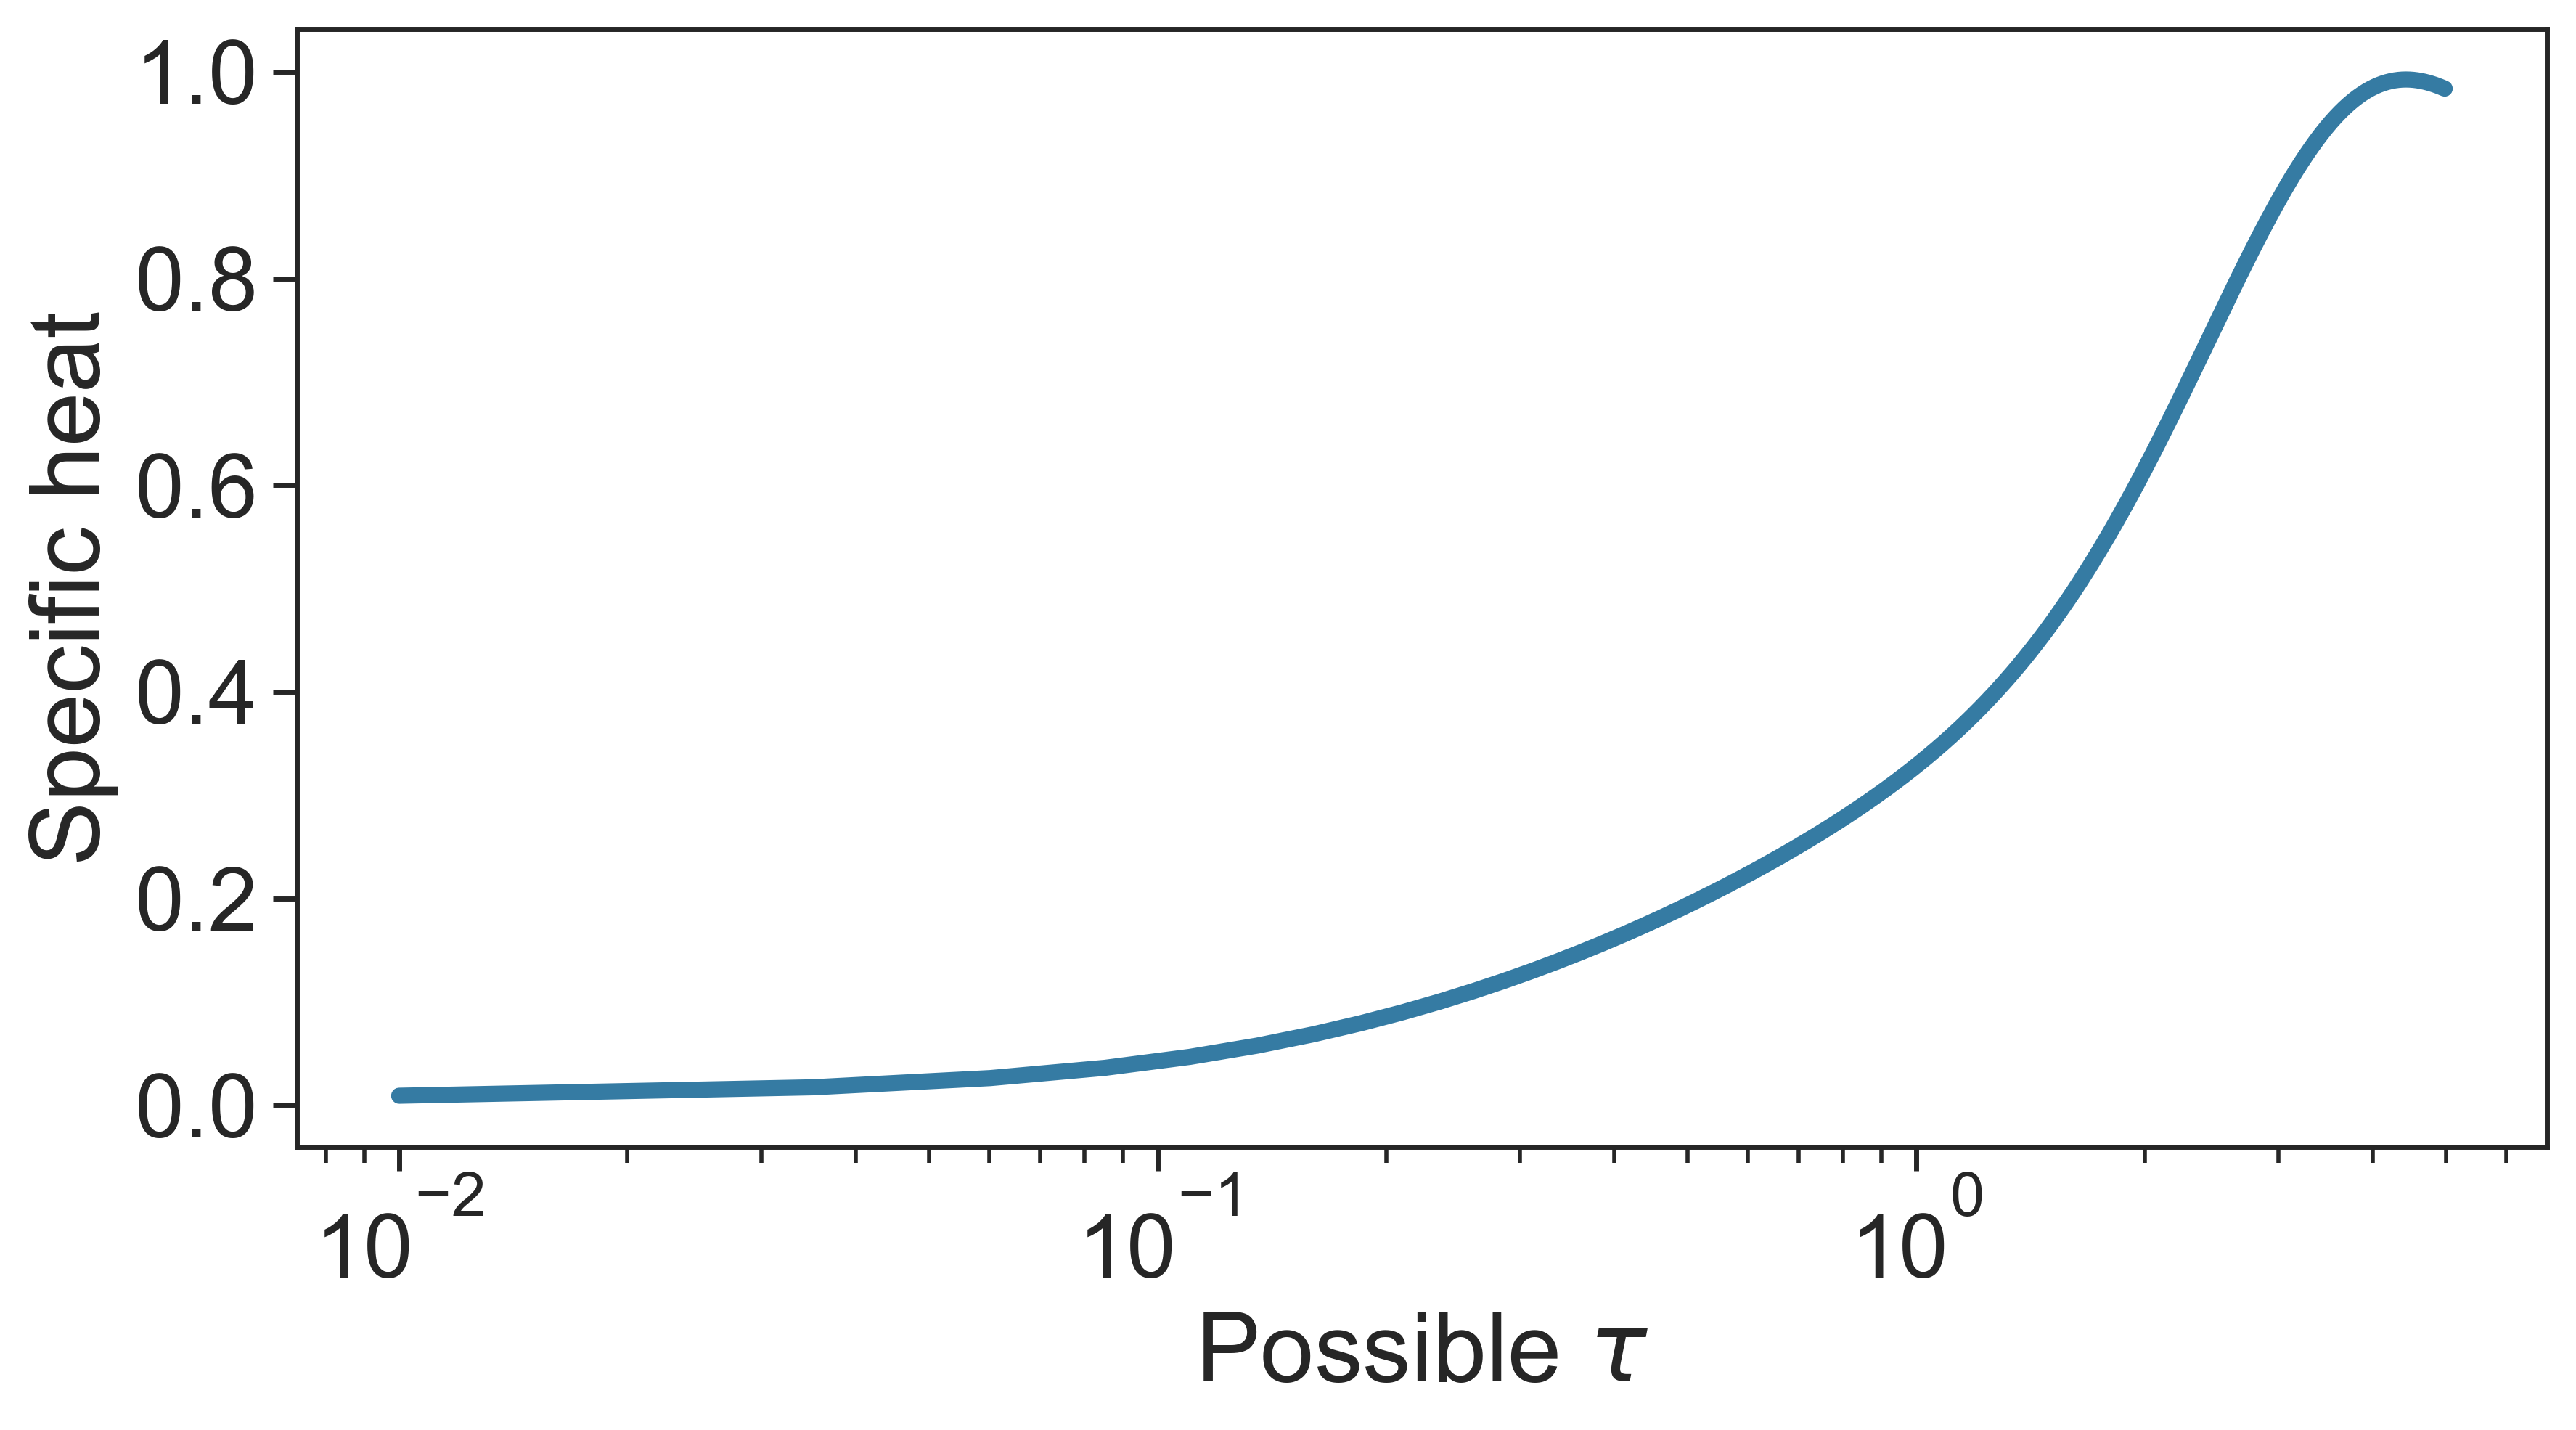

In [54]:
# specific heat
sns.set(context='notebook', style='ticks', font_scale=2)
CVector=C_Lists[0]
colors = plt.cm.GnBu(np.linspace(0, 1, len(CVector)))
plt.figure(dpi=400,figsize=(10,5))
palette = sns.color_palette("mako", len(CVector))
for ID in range(len(CVector)):
    TauVec=np.linspace(0.01, 5, 200) 
    TauVec=TauVec[0:199]
    plt.plot(TauVec, CVector[ID], linewidth=4, c=palette[ID], alpha=1, label='Cluster {}'.format(ID+1))
    print(CVector[ID][np.argmax(CVector[ID])])

plt.ylabel('Specific heat', fontsize=24)
plt.xlabel(r'Possible $\tau$', fontsize=24)
#plt.legend(loc='upper right', fontsize=24)
plt.xscale("log")


[]

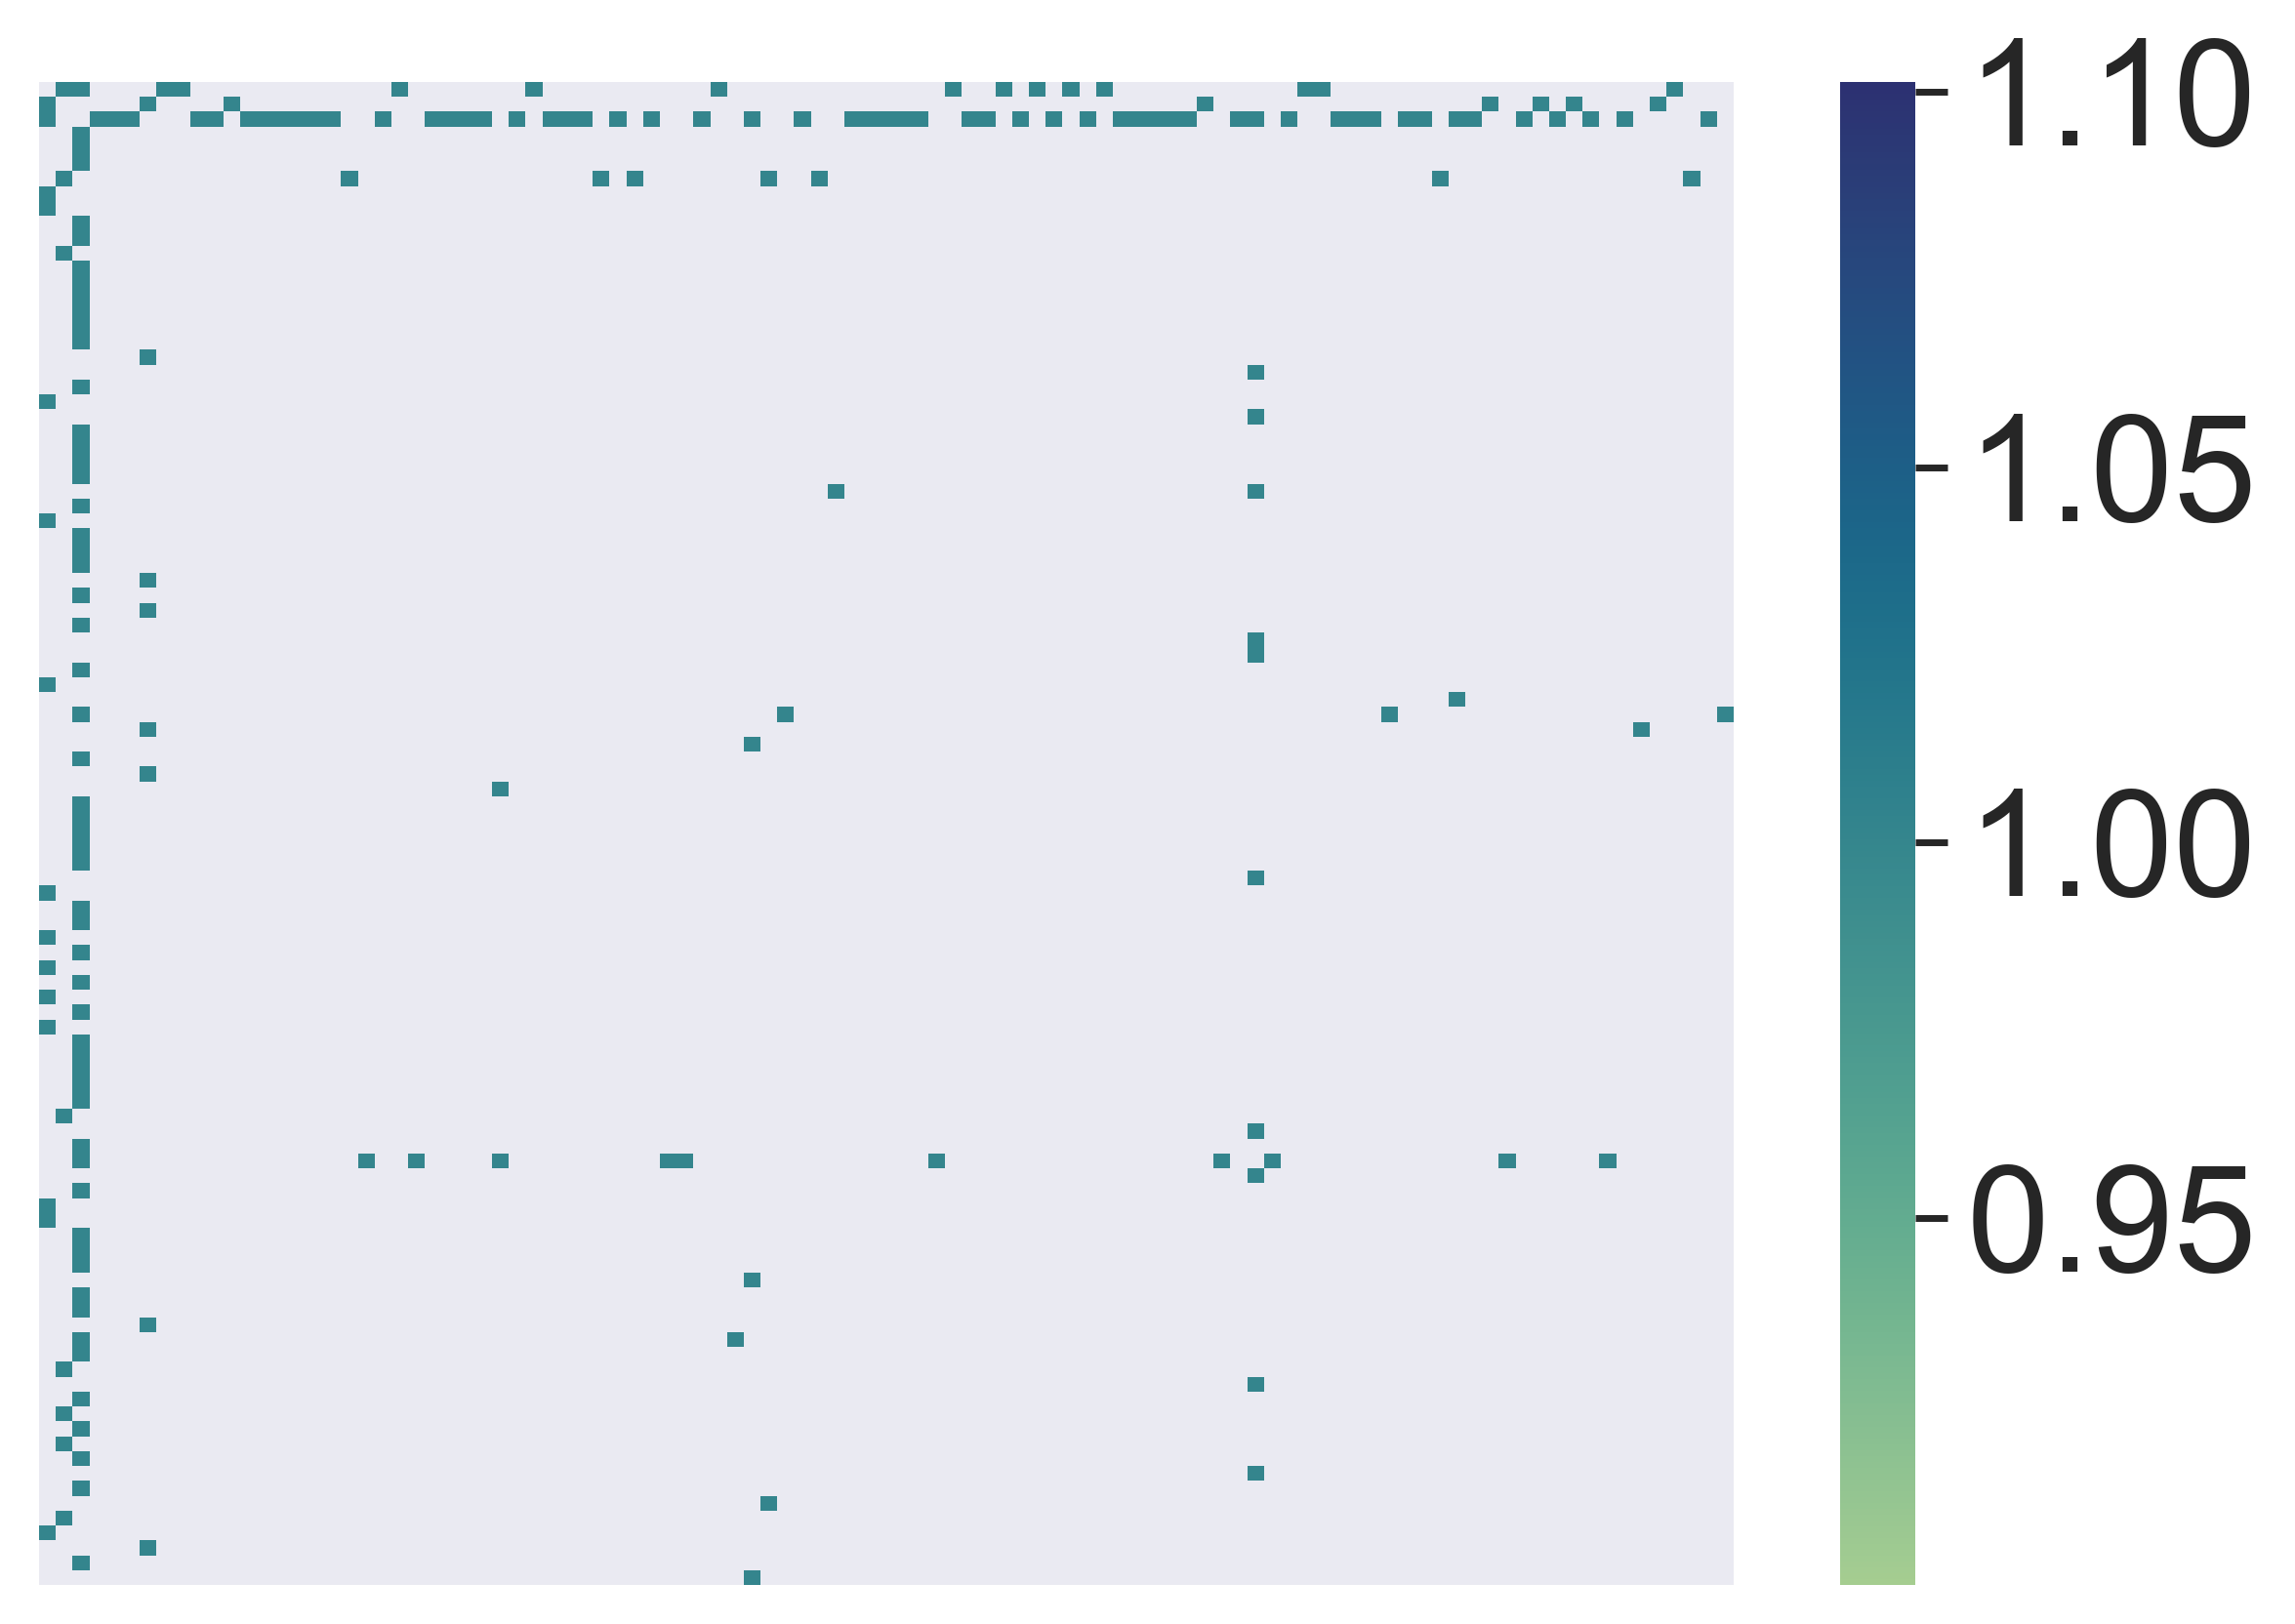

In [56]:
# Laplacian matrix
L_List=L_Lists[1]
L0_List=L0_Lists[1]

InterID=1
L=np.abs(L0_List[InterID]-np.diag(np.diag(L0_List[InterID])))

plt.figure(dpi=400,figsize=(7,5))
sns.set(context='notebook', font_scale=2.5)
ax = sns.heatmap(data=L,linewidth=0, linecolor='black',cmap=sns.color_palette("crest", as_cmap=True), mask=L==0, cbar=True,square=False,annot=False)
x = []
ax.set_xticks(x)
ax.set_yticks(x)

In [58]:
L0_Lists = []
C_Lists = []
for i in range(Sample_Num):
    L0_List = []
    C_List = np.load(osp.join(save_path,'C_s{}.npy'.format(i)))
    for j in range(5):
        L0_j = np.load(osp.join(save_path,'L0_s{}_{}.npy'.format(i,j)))
        L0 = L0_j
        A = np.diag(np.diag(L0)) - L0
        A = (A>0).astype(int)
        L0_j = np.diag(np.sum(A,axis=0)) - A
        L0_List.append(L0_j)
    L0_Lists.append(L0_List)
    C_Lists.append(C_List)

for i in range(4):
    Evals = []
    for j in range(Sample_Num):
        Eval, _ = np.linalg.eig(L0_Lists[j][i])
        Eval = Eval[np.where(Eval>1e-5)[0]]
        Evals += list(Eval)
    np.save(osp.join(save_path,'Evals_step{}'.format(i)),Evals)

plotting BA | MOL | q=1 | p=1 | m=1


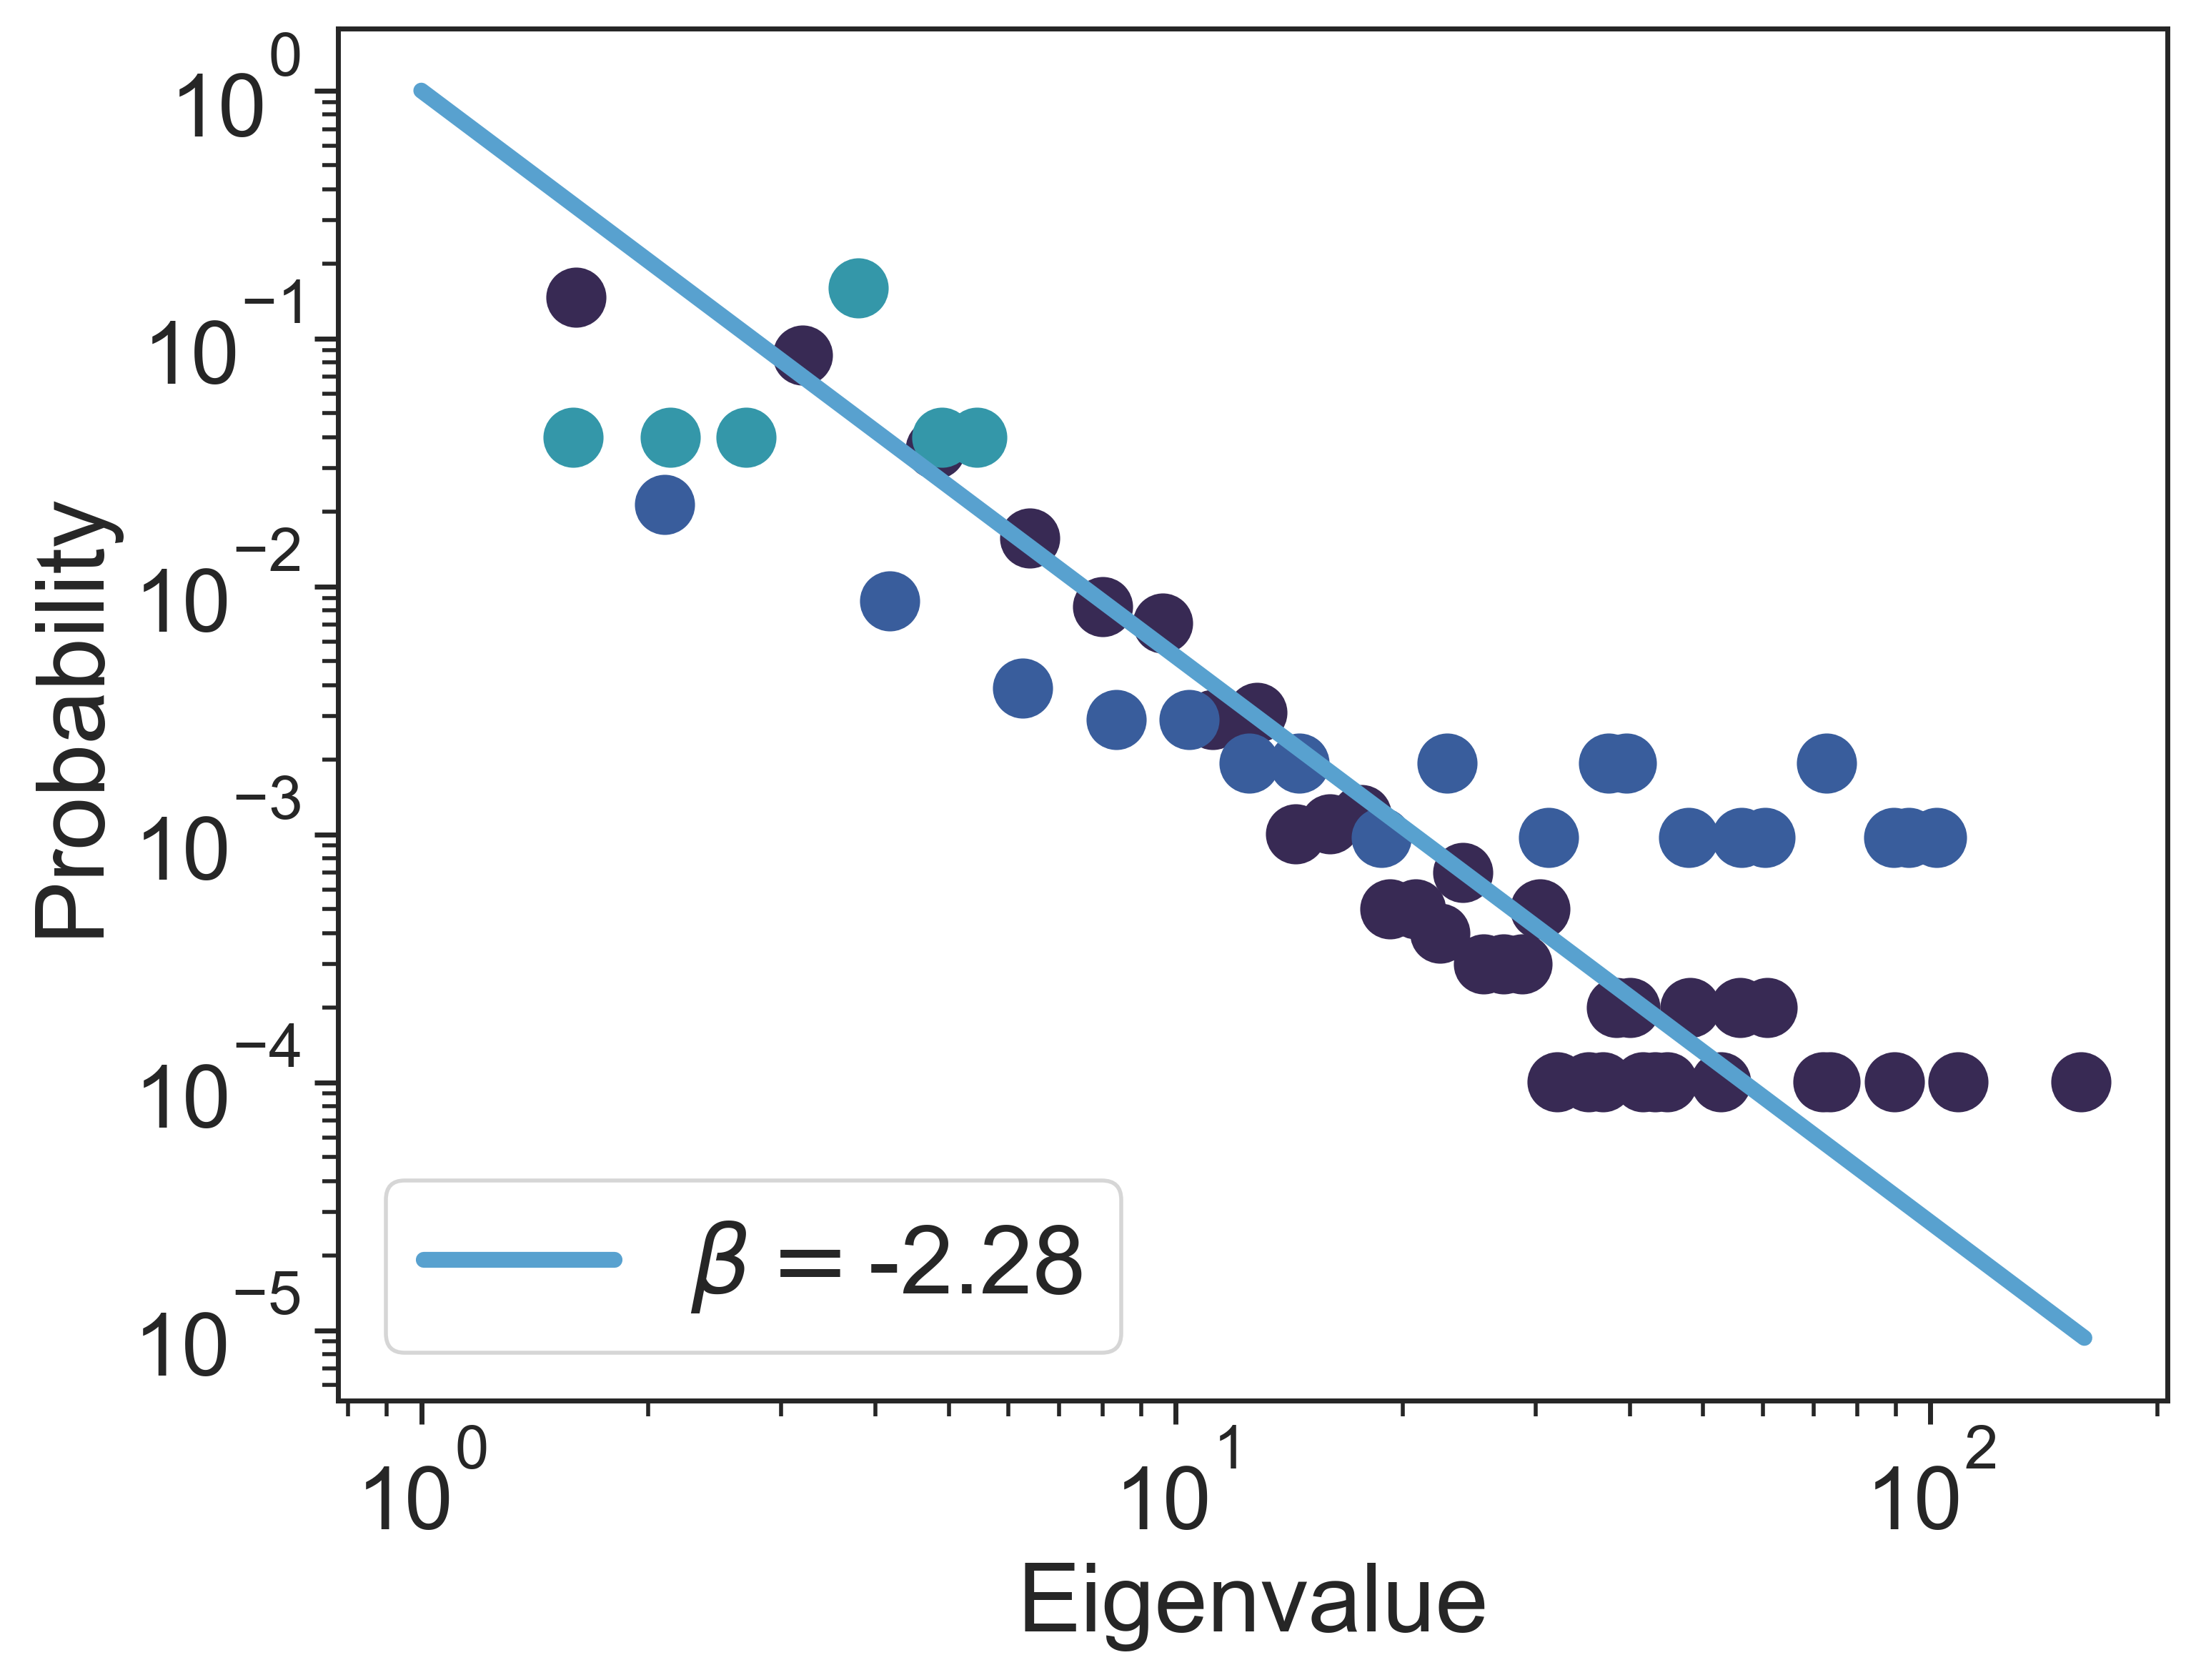

In [60]:
# Laplacian eigenvalue spectrum
print('plotting {} | {} | q={} | p={} | m={}'.format(net_type,L_type,q,p,m))

sns.set(context='notebook', style='ticks', font_scale=2)
colors = sns.color_palette("mako", 4)
fit_color = get_plot_colors(10, type='Blues')[5]
fig = plt.figure(dpi=400,figsize=(8,6))
fig.subplots_adjust(hspace=0.5, wspace=0.05)
fig.subplots_adjust(left=0.15,right=0.95,top=0.95,bottom=0.15)
X_list, Y_list, xmin_list, Evals_list = [], [], [], []
for i in range(0,4):
	Evals = np.load(osp.join(save_path,'Evals_step{}.npy'.format(i)))
	Evals = np.real(Evals[np.where(Evals>0)[0]])
	if len(np.unique(Evals))>1:
		if i==0:
			n_bin=100
		elif i==1:
			n_bin=50
		elif i==2:
			n_bin=10
		# n_bin=100
		# Evals = InverseTransformSampling(Evals, n_bin, 100000)
		# hists, EvalBin = np.histogram(Evals, bins=100)
		hists, EvalBin = np.histogram(Evals, bins=n_bin)
		if len(np.unique(hists))>=2:
			EvalProb = hists/sum(hists)
			Fit0 = powerlaw.Fit(Evals,xmin=1)
			xmin = Fit0.xmin

			X_list.append(EvalBin[:-1])
			Y_list.append(EvalProb[:])
			xmin_list.append(xmin)
			Evals_list.append(Evals)
eval_cut = min(xmin_list)
All_Evals = np.concatenate(Evals_list)
Fit1 = powerlaw.Fit(All_Evals, xmin=eval_cut)
x = np.linspace(eval_cut, max(All_Evals), 100)
y = np.power(x/eval_cut, -Fit1.alpha)
plt.plot(x,y,linestyle ='-',color=fit_color,linewidth=4, label=r'$\beta=$'+'{:.2f}'.format(-Fit1.alpha))


for id in range(len(xmin_list)):
	x = X_list[id][:]
	y = Y_list[id][:]
	idx = np.where(x>xmin_list[id])[0]
	x = x[idx]
	y = y[idx]
	plt.scatter(x, y,s=200, color=colors[id])
plt.legend(loc='lower left', fontsize=24)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Eigenvalue', fontsize=24)
plt.ylabel('Probability', fontsize=24)
plt.show()